At first we need to install some libraries

In [1]:
import numpy as np
try:
  import pysindy
except ModuleNotFoundError:
  !pip install --quiet pysindy
  import pysindy as ps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.6 MB/s eta 0:00:00


Perform some initial calculations

In [2]:
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)

Writing a fourier basis as basis function

In [3]:
model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.FourierLibrary(),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x7fed930f5d20>,
      feature_names=['x', 'y'], optimizer=STLSQ(threshold=0.2))

Now, that we have fitted the model, we can investigate the print member function

In [4]:
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)


In [5]:
import matplotlib.pyplot as plt
def plot_simulation(model, x0, y0):
    t_test = np.linspace(0, 1, 100)
    x_test = x0 * np.exp(-2 * t_test)
    y_test = y0 * np.exp(t_test)

    sim = model.simulate([x0, y0], t=t_test)

    plt.figure(figsize=(6, 4))
    plt.plot(x_test, y_test, label="Ground truth", linewidth=4)
    plt.plot(sim[:, 0], sim[:, 1], "--", label="SINDy estimate", linewidth=3)
    plt.plot(x0, y0, "ko", label="Initial condition", markersize=8)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

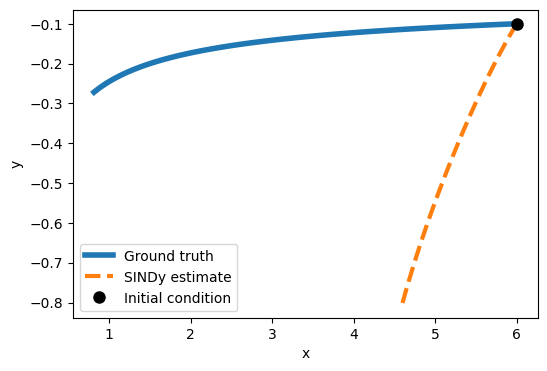

In [7]:
x0 = 6
y0 = -0.1
plot_simulation(model, x0,y0)

Above we can see fourier basis is not a good example

**Exercise 1** Let’s investigate what happens if we choose a different basis function.

Implement a Sindy algorithm class with a Fourier basis by initializing `ps.SINDy()` with the feature_library attribute set to `ps.PolynomialLibrary()`. Fit the instantiated algorithm with the `.fit(X, t=t)` method.

In [8]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=1),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=1), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [9]:
model_1.print()

(x)' = -2.000 x
(y)' = 1.000 y


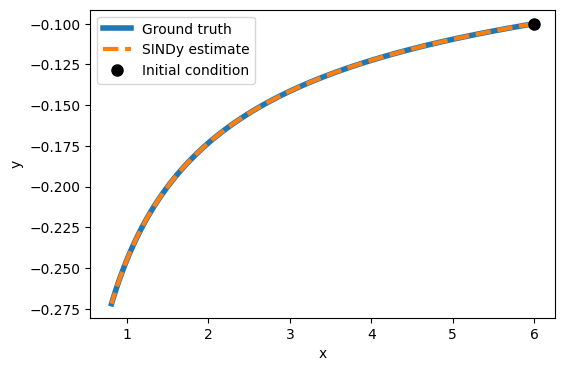

In [10]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

**Exercise 1.1** At which degree is SINDy not able anymore to correctly identify the equation? At which degree do the predictions on a test set diverge? Test this by successively increasing the degree of the polynomial.

In [11]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=4),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [12]:
model_1.print()

(x)' = -1.280 x + -0.960 x^2 y^2
(y)' = 1.000 y


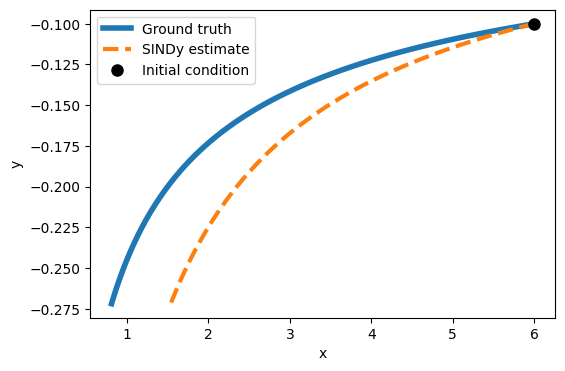

In [13]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

**Exercise 1.2** What happens if you set the threshold too low? What if it is too high?

**threshold :** minimum magnitude for a coefficient in the weight vector. Coefficients with magnitude below the threshold are set to zero.

In [14]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=4),
    optimizer=ps.STLSQ(threshold=0.1),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4), feature_names=['x', 'y'],
      optimizer=STLSQ())

In [15]:
model_1.print()

(x)' = -1.277 x + 0.001 x^2 + -0.002 x y + -0.005 x^2 y + -0.958 x^2 y^2
(y)' = 0.640 y + 0.480 x y^3


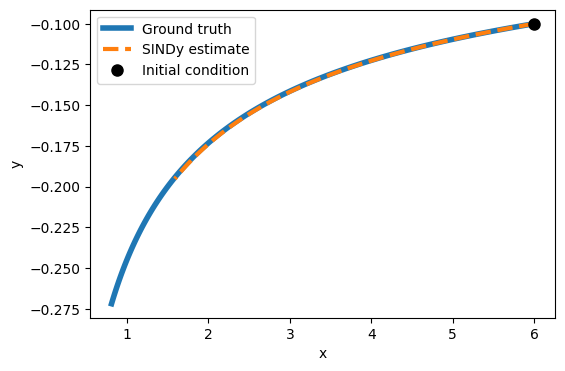

In [16]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

#### **Lorenz attractor**

SINDy on the Lorenz attractor we first simulate a trajectory from the ground truth equations:

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 40.0, dt)

x_train = odeint(f, state0, time_steps)

In the above code, we used odeint function to perform Ordinary differentiation

In [18]:
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=2),
)

model.fit(x_train, t=dt)

x_sim = model.simulate(x_train[0], time_steps)

In [19]:
model.print()

(x0)' = -9.977 x0 + 9.977 x1
(x1)' = 27.807 x0 + -0.962 x1 + -0.995 x0 x2
(x2)' = -2.659 x2 + 0.997 x0 x1


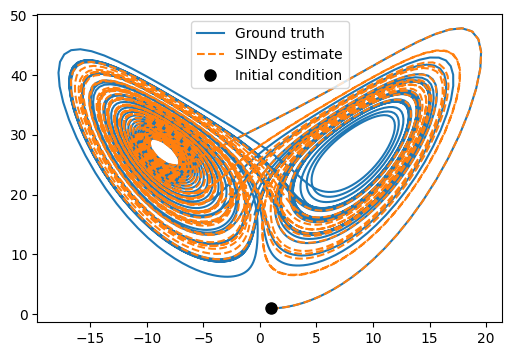

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:, 0], x_train[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

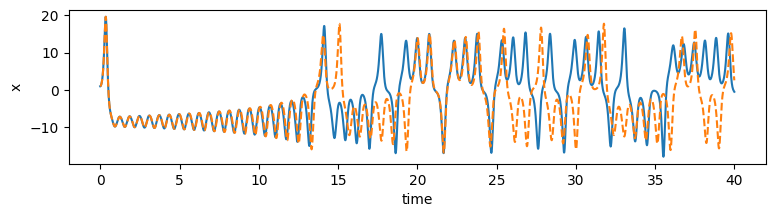

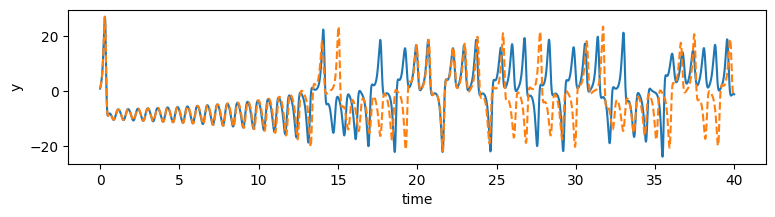

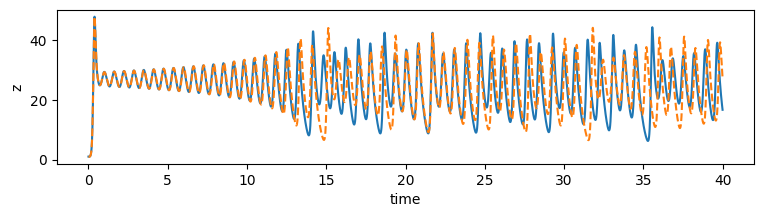

In [21]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)

plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')

**Challenges:** Sparse require extremely clean data, if the data is clean little can produce great results otherwise you have to perform a trade off by performing integration on the noisy data.

**Reservoir computing is a simple method for training recurrent neural networks without backpropagation through time and the associated notorious vanishing and exploding gradient problems.**


*   *Randomly initialize recurrent neural network weights.*

* *Fix hidden connection weights.*

* *Train linear output layer with linear regression.* 

In [22]:
from scipy import sparse

radius = 0.6
sparsity = 0.01
input_dim = 3
reservoir_size = 1000
n_steps_prerun = 10
regularization = 1e-2
sequence = x_train

Randomly initialize the network weights:

In [23]:
weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity)
eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
weights_hidden = weights_hidden / np.max(np.abs(eigenvalues)) * radius

weights_input = np.zeros((reservoir_size, input_dim))
q = int(reservoir_size / input_dim)
for i in range(0, input_dim):
    weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1

weights_output = np.zeros((input_dim, reservoir_size))

Embed the sequence into the hidden state of the network:

In [24]:
def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
    hidden = np.zeros((reservoir_size, 1))
    for t in range(n_steps_prerun):
        input = sequence[t].reshape(-1, 1)
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    return hidden

def augment_hidden(hidden):
    h_aug = hidden.copy()
    h_aug[::2] = pow(h_aug[::2], 2.0)
    return h_aug

hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
hidden_states = []
targets = []

for t in range(n_steps_prerun, len(sequence) - 1):
    input = np.reshape(sequence[t], (-1, 1))
    target = np.reshape(sequence[t + 1], (-1, 1))
    hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    hidden = augment_hidden(hidden)
    hidden_states.append(hidden)
    targets.append(target)

targets = np.squeeze(np.array(targets))
hidden_states = np.squeeze(np.array(hidden_states))

Ridge regression to obtain the linear output layer weights:

In [25]:
weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

In [26]:
def predict(sequence, n_steps_predict):
    hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
    input = sequence[n_steps_prerun].reshape((-1, 1))
    outputs = []

    for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
        hidden = augment_hidden(hidden)
        output = weights_output @ hidden
        input = output
        outputs.append(output)
    return np.array(outputs)

In [27]:
x_sim = predict(sequence, 4000)

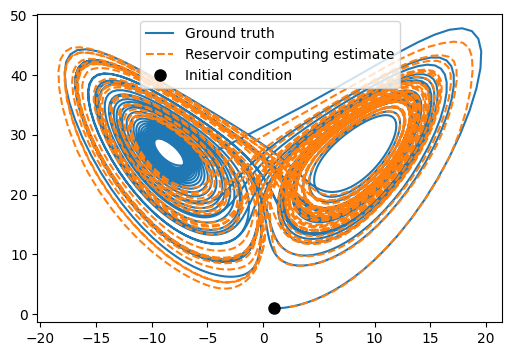

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:4000, 0], x_train[:4000, 2], label="Ground truth")
plt.plot(x_sim[:, 0], x_sim[:, 2],'--', label="Reservoir computing estimate")
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)

plt.legend()
plt.show()

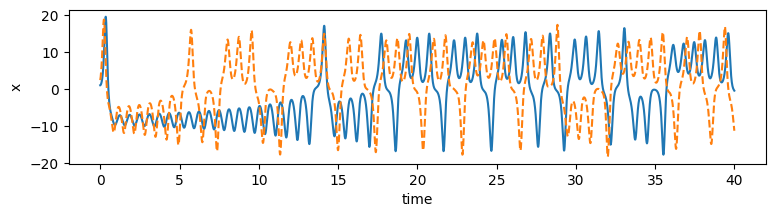

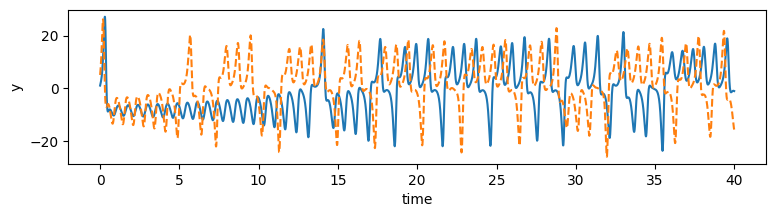

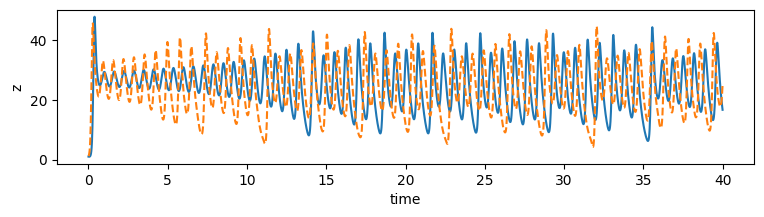

In [29]:
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')